In [1]:
from hypergraph import *

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

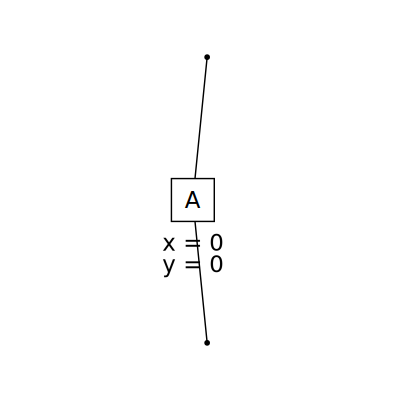

In [3]:
starting_graph = Graph({
  0: vertex((0, -1)),
  1: vertex((0,  1)),
  2: hyperedge((-0.1, 0), "A", [0, 1], attrs = { "x": 0, "y": 0 })
})

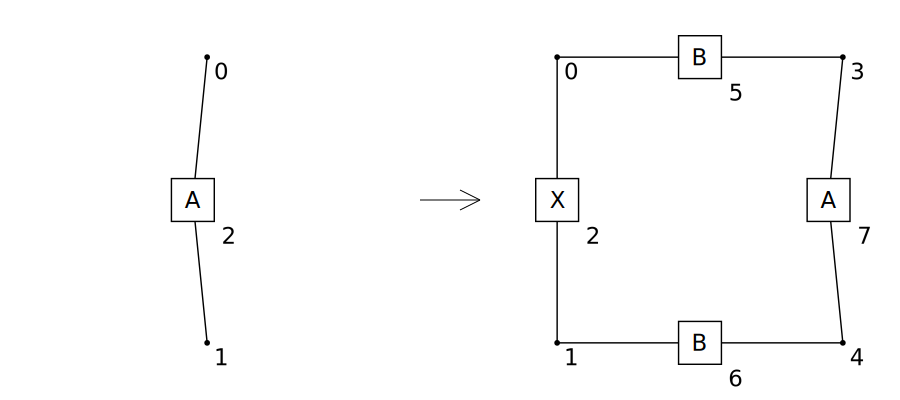

In [4]:
prod = Production(
    left = Graph({
        0: vertex((0, -1)),
        1: vertex((0,  1)),
        2: hyperedge((-0.1, 0), "A", [0, 1])
    }),
    right = Graph({
        0: vertex((0, -1)),
        1: vertex((0,  1)),
        2: hyperedge((0, 0), "X", [0, 1]),
        3: vertex((2, -1)),
        4: vertex((2,  1)),
        5: hyperedge((1, -1), "B", [0, 3]),
        6: hyperedge((1,  1), "B", [1, 4]),
        7: hyperedge((1.9,  0), "A", [3, 4]),
    }),
    seed_node = 2,
    attributes = lambda nodes: {
        7: {
            "x": nodes[2].attrs["x"] + 1,
            "y": nodes[2].attrs["y"]
        }
    },
    predicate = lambda nodes: nodes[2].attrs["x"] < 3
)

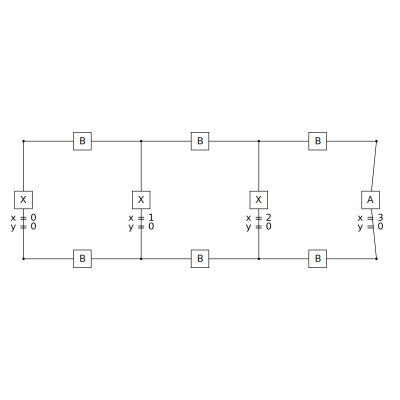

In [5]:
graph = starting_graph
graph = prod.apply_many(graph)

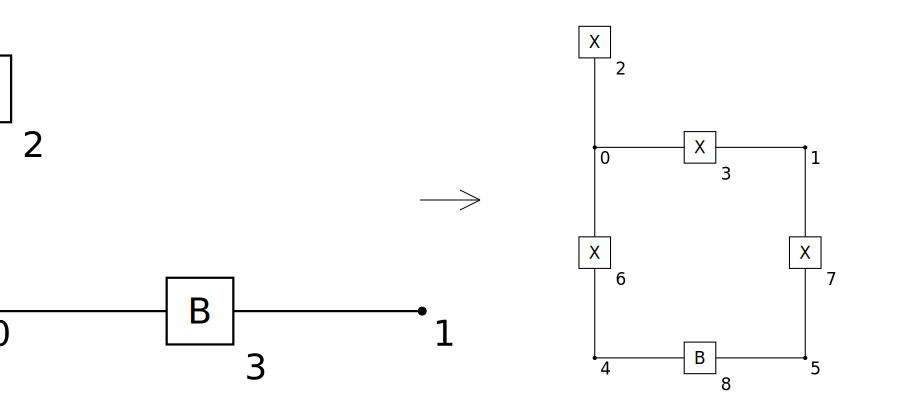

In [6]:
prod2 = Production(
  left = Graph({
    0: vertex((-1, 0)),
    1: vertex((1, 0)),
    2: hyperedge((-1, -1), "X", [0]),
    3: hyperedge((0, 0), "B", [0, 1])
  }), 
  right = Graph({
    0: vertex((-1, 0)),
    1: vertex((1, 0)),
    2: hyperedge((-1, -1), "X", [0]),
    3: hyperedge((0, 0), "X", [0, 1]),
    
    4: vertex((-1, 2)),
    5: vertex((1, 2)),
    6: hyperedge((-1, 1), "X", [0, 4]),
    7: hyperedge((1, 1), "X", [1, 5]),
    8: hyperedge((0, 2), "B", [4, 5])
  }),
  seed_node = 3,
)

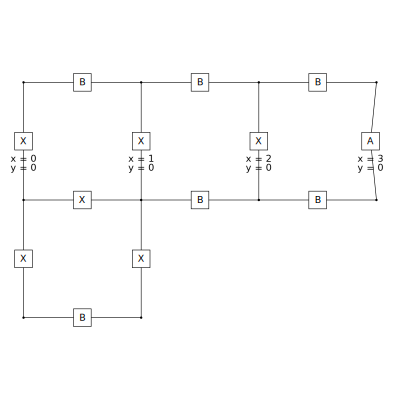

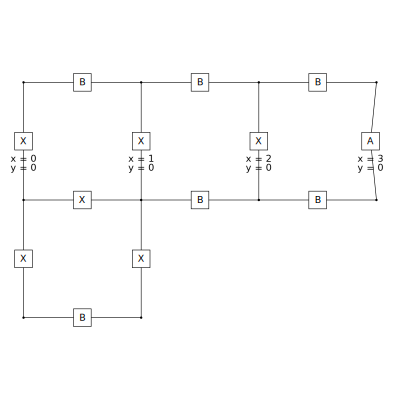

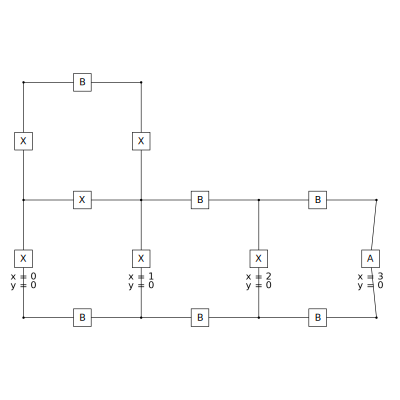

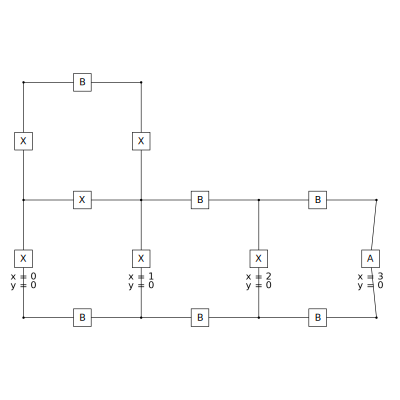

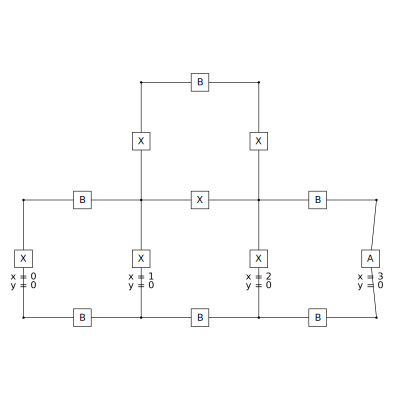

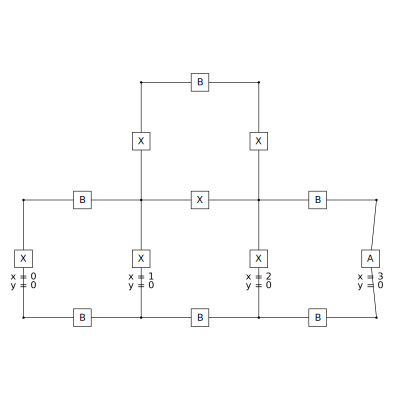

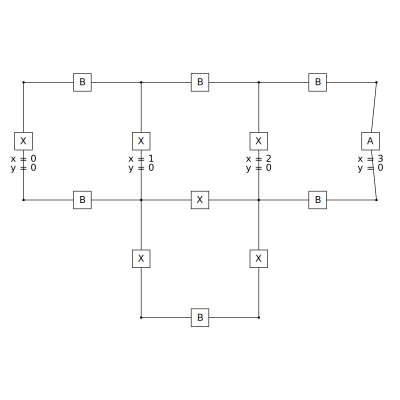

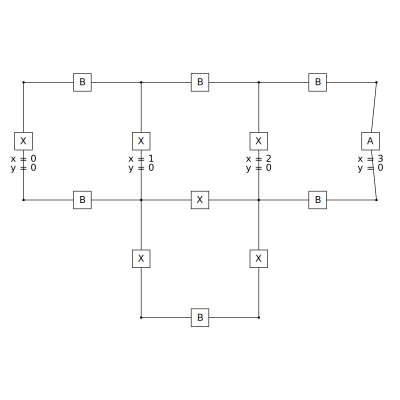

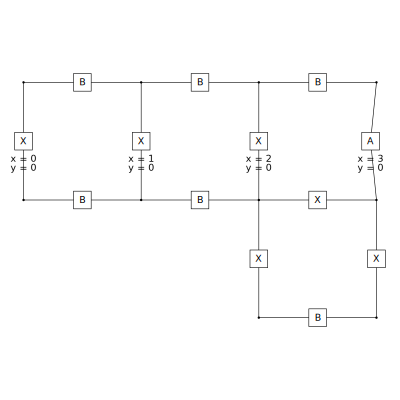

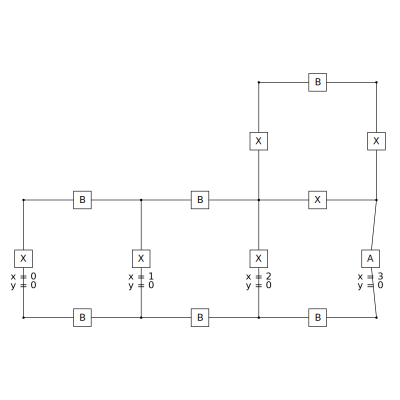

In [7]:
for g in prod2.apply_all_possible(graph):
  display(g)